The objective of this script is to detect the cryptic pockets based on the 
volume oscillation.

In [1]:
import os
import fnmatch
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
import numpy as np

/tmp/ipykernel_27502/3601556291.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
pocket_dir = "/home/alex/Desktop/pockets_mounted/"

In [14]:
def read_descriptors_file(file_path):
    """
    Read a tab-separated file and return a dictionary where each key is a
    column name and each value is a list of column values.

    Args:
        file_path (str): Path to the tab-separated file.

    Returns:
        dict: A dictionary with column names as keys and lists of values as
        values.
    """
    values = {}
    fh = open(file_path, 'r')

    # Read the header line and initialize the values dictionary
    header = fh.readline()
    for field in header.split():
        values[field] = []
    
    # Read the rest of the file and populate the values dictionary
    for line in fh:
        fields = line.split()
        for i, field in enumerate(header.split()):
            values[field].append(fields[i])

    fh.close()
    return values


def moving_average(data, window_size):
    """
    Calculate the moving average of a list of numbers.

    Args:
        data (list): List of numbers.
        window_size (int): Size of the moving average window.

    Returns:
        list: List of moving averages.
    """
    if not data or window_size <= 0:
        return []

    cumsum = [0] * (len(data) + 1)
    for i, x in enumerate(data):
        cumsum[i + 1] = cumsum[i] + x

    return [(cumsum[i + window_size] - cumsum[i]) / window_size
            for i in range(len(data) - window_size + 1)]


def get_openness(volumes, open_threshold=160, closed_threshold=50):
    """
    Determine the openness of pockets based on volume values.

    Args:
        volumes (list): List of volume values.
        open_threshold (float): Threshold above which a pocket is considered 
            open.
        closed_threshold (float): Threshold below which a pocket is considered
            closed.

    Returns:
        list: List of openness states ('open', 'closed', 'inter') for each volume
            value.
    """
    openness = []
    for volume in volumes:
        if volume >= open_threshold:
            openness.append('open')
        elif volume < closed_threshold:
            openness.append('closed')
        else:
            openness.append('inter')
    return openness


def cluster_by_opening(volumes_opening):
    """
    Cluster the volume states by their openness.

    Args:
        volumes_opening (list): List of openness states ('open', 'closed',
            'inter').
    
    Returns:
        list: List of tuples where each tuple contains a state and the number
        of consecutive occurrences of that state.
    """
    clusters = []
    prev_x = volumes_opening[0]
    n_consecutive = 1
    for x in volumes_opening[1:]:
        if x != prev_x:
            clusters.append((prev_x, n_consecutive))
            prev_x = x
            n_consecutive = 1
        else:
            n_consecutive += 1
    clusters.append((prev_x, n_consecutive)) # Append the last cluster
    return clusters


# def check_if_cryptic(clusters, min_length=100):
#     """
#     """
#     if clusters[0][0] != 'closed' or clusters[0][1] < min_length:
#         return False
    
#     if any(x[0] == 'open' and x[1] >= min_length for x in clusters):
#         return True

#     return False


def get_n_closed_at_start(clusters):
    """
    Get the number of consecutive 'closed' states at the start of the clusters.
    Args:
        clusters (list): List of tuples where each tuple contains a state and
            the number of consecutive occurrences of that state.

    Returns:
        int: Number of consecutive 'closed' states at the start of the
            clusters.
    """
    n_closed_start = 0
    if clusters[0][0] != "closed":
        n_closed_start = 0
    else:
        n_closed_start = clusters[0][1]
    return n_closed_start


def get_max_n_open(clusters):
    """
    Get the maximum number of consecutive 'open' states in the clusters.
    Args:
        clusters (list): List of tuples where each tuple contains a state and
            the number of consecutive occurrences of that state.
    Returns:
        int: Maximum number of consecutive 'open' states in the clusters.
    """
    n_open_cluster = 0
    for cluster in clusters:
        if cluster[0] == 'open':
            if cluster[1] > n_open_cluster:
                n_open_cluster = cluster[1]
    return n_open_cluster


def find(pattern, path):
    """
    Find all files matching a given pattern in a directory and its
    subdirectories.

    Args:
        pattern (str): The pattern to match files against.
        path (str): The directory path to search in.
    Returns:
        generator: A generator yielding paths of files that match the pattern.
    """
    for root, dirs, files in os.walk(path):
        for name in files:
            if fnmatch.fnmatch(name, pattern):
                yield os.path.join(root, name)

                
def get_perc_in_state(volumes_opening):
    """
    Calculate the percentage of time spent in each state (open, closed, inter).

    Args:
        volumes_opening (list): List of states.

    Returns:
        dict: Dictionary with states as keys and their percentages as values.
    """
    total = len(volumes_opening)
    
    counts = {'open': 0, 'closed': 0, 'inter': 0}
    for state in volumes_opening:
        counts[state] += 1

    return {state: (count / total) * 100 for state, count in counts.items()}


def extract_ids(path):
    """
    Extracts trajectory ID, dynID, and pocket ID from a given file path.
    
    Parameters:
        path (str): The full file path.
        
    Returns:
        dict: A dictionary with keys 'trajectory_id', 'dyn_id', and 'pocket_id'.
    """
    # Match descriptorPockets_<traj_id>_trj_<dyn_id>.xtc
    trajectory_match = re.search(r'descriptorPockets_(\d+)_trj_(\d+)\.xtc', path)
    # Match pocket_num_<pocket_id>_descriptors.txt
    pocket_match = re.search(r'pocket_num_(\d+)_descriptors\.txt', path)

    if trajectory_match and pocket_match:
        traj_id = trajectory_match.group(1)
        dyn_id = trajectory_match.group(2)
        pocket_id = pocket_match.group(1)

        return (traj_id, dyn_id, pocket_id)
    else:
        print(f"Could not extract all required IDs from the path: {path}.")
        return None, None, None


def plot_volumes(dynid, trajid, pocketid, window_size=20):
    """
    Plot the smoothed volume of a pocket over time.
    Args:
        dynid (int): The dynamic ID of the trajectory.
        trajid (int): The trajectory ID.
        pocketid (int): The pocket ID.
        window_size (int): The size of the moving average window.
    """
    file = f"/home/alex/Desktop/mdpocket_oversized_mount_tmp/{trajid}_trj_{dynid}.xtc_mdpocket/descriptorPockets_{trajid}_trj_{dynid}.xtc/pocket_num_{pocketid}_descriptors.txt"
    values_dict = read_descriptors_file(file)
    volumes = list(map(float, values_dict['pock_volume'])) # Convert to float
    smoothed_volume = moving_average(volumes, window_size=window_size)
    plt.xlabel('Time (ns)')
    plt.ylabel('Volume (A³)')
    plt.plot(smoothed_volume, color="violet")
    


def plot_multiple_volumes(list_of_ids, window_size=20):
    """
    Plot the smoothed volumes of multiple pockets over time.
    
    Args:
        list_of_ids (list): List of tuples containing (dynid, trajid, pocketid).
        window_size (int): The size of the moving average window.
    """
    for dynid, trajid, pocketid in list_of_ids:
        plot_volumes(dynid, trajid, pocketid, window_size=window_size)
    
    plt.xlabel('Time')
    plt.ylabel('Volume')
    # plt.title('Pocket Volumes Over Time')
    # plt.legend([f'Dyn {dynid}, Traj {trajid}, Pocket {pocketid}' for dynid, trajid, pocketid in list_of_ids])
    plt.show()



In [36]:
df_dict = {
    'dyn_id': [],
    'traj_id': [],
    'pocket_id': [],
    'n_closed_start': [],
    'n_max_open': [],
    'perc_open': [],
    'perc_closed': [],
    'perc_inter': [],
}

for index, file in enumerate(find("pocket_num_*_descriptors.txt", pocket_dir)):
    try:
        # Extract IDs from the file path
        traj_id, dyn_id, pocket_id = extract_ids(file)
        if traj_id == None:
            continue

        # Get the volumes and smooth them
        values_dict = read_descriptors_file(file)
        volumes = list(map(float, values_dict['pock_volume'])) # Convert to float
        smoothed_volume = moving_average(volumes, window_size=20)

        # Calculate the openness of the pocket and make some stats
        volumes_opening = get_openness(smoothed_volume)
        perc_state = get_perc_in_state(volumes_opening)
        clusters = cluster_by_opening(volumes_opening)
        n_closed_start = get_n_closed_at_start(clusters)
        n_max_open = get_max_n_open(clusters)

        # Store the results in the dictionary
        df_dict['dyn_id'].append(dyn_id)
        df_dict['traj_id'].append(traj_id)
        df_dict['pocket_id'].append(pocket_id)
        df_dict['n_closed_start'].append(n_closed_start)
        df_dict['n_max_open'].append(n_max_open)
        df_dict['perc_open'].append(perc_state['open'])
        df_dict['perc_closed'].append(perc_state['closed'])
        df_dict['perc_inter'].append(perc_state['inter'])

        # if index == 20: # for testing purposes, limit to 20 files
        #     break
    except Exception as e:
        print(f"Error processing file {file} (index {index}): {e}")
        continue

df = pd.DataFrame(df_dict)

NameError: name 'pocket_dir' is not defined

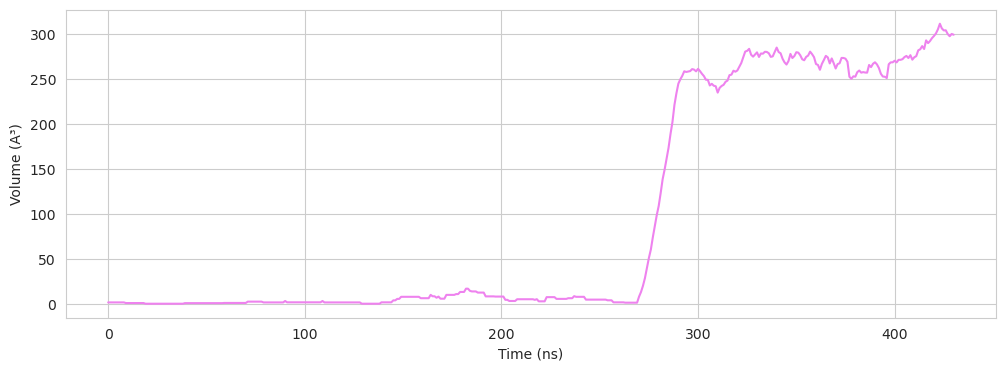

In [15]:
plt.figure(figsize=(12, 4))
sns.set_style("whitegrid")
plot_volumes(dynid=143, trajid=11357, pocketid=12)

Plotting the cryptic pocket volumes

In [4]:
def get_target_ids(csv_path):
    """
    Extracts unique dynamic IDs, trajectory IDs, and pocket IDs from a CSV
    file.
    """
    df = pd.read_csv(csv_path)
    dyn_ids = df["dyn_id"]
    traj_ids = df["traj_id"]
    pocket_ids = df["pocket_id"]

    return zip(dyn_ids, traj_ids, pocket_ids)


def plot_volumes(dynid, trajid, pocketid, color, window_size=20):
    """
    Plot the smoothed volume of a pocket over time.
    Args:
        dynid (int): The dynamic ID of the trajectory.
        trajid (int): The trajectory ID.
        pocketid (int): The pocket ID.
        window_size (int): The size of the moving average window.
    """
    file = f"/home/alex/Desktop/mdpocket_oversized_mount_tmp/{trajid}_trj_{dynid}.xtc_mdpocket/descriptorPockets_{trajid}_trj_{dynid}.xtc/pocket_num_{pocketid}_descriptors.txt"
    values_dict = read_descriptors_file(file)
    volumes = list(map(float, values_dict['pock_volume'])) # Convert to float
    smoothed_volume = moving_average(volumes, window_size=window_size)
    plt.plot(smoothed_volume, alpha=0.6, color=color)
    plt.xlim(0, 500)

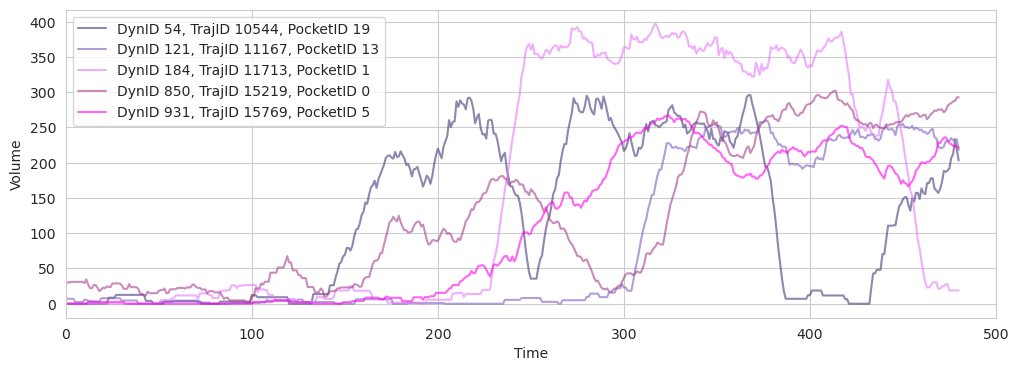

In [90]:

input_csv_path = "/home/alex/Documents/pocket_tool/results/02_cryptic_pocket_detection/00_detecting_based_on_volume/output_250730/cryptic_pockets_filtered_100_100.csv"
ROOT_GPCRMD = "/home/alex/Desktop/gpcrmd_mount/media/computation/files"

plt.figure(figsize=(12, 4))
sns.set_style("whitegrid")
purple_palette = ["#433878", "#7E60BF", "#E779FF", "#A63F8B", "#FF00EE"]
list_of_ids = list(get_target_ids(input_csv_path))

list_of_ids_used = []
color_used = 0
for index, (dynid, trajid, pocketid) in enumerate(list_of_ids):
    if index in [11,20,30,36,40]: #11,20,30, 40, 36
        plot_volumes(dynid, trajid, pocketid, color=purple_palette[color_used], window_size=20)
        color_used += 1
        list_of_ids_used.append((dynid, trajid, pocketid))
    
plt.xlabel('Time')
plt.ylabel('Volume')
# plt.title('Pocket Volumes Over Time')
plt.legend([f'DynID {dynid}, TrajID {trajid}, PocketID {pocketid}' for dynid, trajid, pocketid in list_of_ids_used])
plt.show()

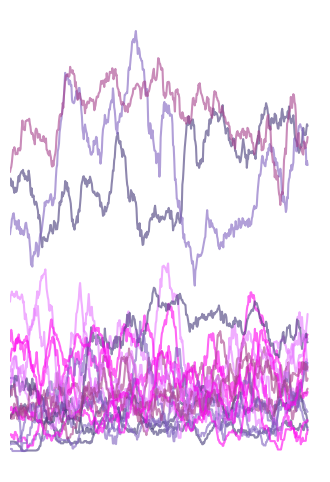

In [15]:
sns.set_style("whitegrid")
plt.figure(figsize=(4, 6))
# No axis
plt.axis('off')
purple_palette = ["#433878", "#7E60BF", "#E779FF", "#A63F8B", "#FF00EE"]
for pocket_id in range(0, 20):
    purple = purple_palette[pocket_id % len(purple_palette)]
    plot_volumes(dynid=30, trajid=10341, pocketid=pocket_id, color=purple, window_size=20)
